# 1. Method 1

1. Bootstrap sample two samples from null population, and assign as `candidate` and `noncandidate`. Repeat 1000 times. 

>`whole_sample = candidate.append(noncandidate)`

>`mock_candidate = bs(whole_sample)`

>`mock_noncandidate = bs(whole_sample)`

2. Calculate null population mean and standard deviation of `mock_candidate - mock_candidate`
3. Calculate sample mean from the original candidate/noncandidate pool of dfe_alpha output values.
4. Calculate p-value.

>`p-value = number of (mean(bs(mock_candidate))- mean(bs(mock_noncandidate))) greater than (mean(sample_candidate) - mean(sample_noncandidate))/ number of bootstrap runs`


### Rob's explanation: 

- get 100 DFE-alpha results by doing bootstraps of Candidates

- then get 100 DFE-alpha results by sampling N noncandidate genes from the genome where N is the number of genes in Candidates

- once you have these two sets of 100 BS runs of DFE-alpha

- You pool the runs into 200 DFE results

- 1000 x (Sample 100 values from the pool to make mock(Candidate) and 100 values from the pool to make mock(NonCandidate)
     for each DFE stat you want:
            calc mean(mock(Candidate)) - mean(mock(Noncandidate))


- For each of the DFE stats you will have 1000 values that represent the difference in the mock samples

- Ask this question: How many of those 1000 differences is bigger than  the mean ( real 100 Candidate bootstraps) - mean(100 non-- candidate bootstraps)


In [1]:
import pandas as pd
from sklearn.utils import resample
import random
import matplotlib.pyplot as plt
from scipy import stats
import math

In [2]:
df = pd.read_csv("../../data/dfe_alpha_analysis/20210204_composite_genome/bootstrap_values.txt", sep='\t')
df.columns = ["group","alpha", "omega","pFDM", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"]
df = df.drop(columns=["pFDM"])

In [3]:
df.head()

,group,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
0,noncandidate,0.264506,0.085500,0.252094,0.061857,0.077035,0.609015
1,candidate,0.486018,0.145958,0.166344,0.055530,0.074067,0.704058
2,noncandidate,0.203251,0.064773,0.266185,0.050104,0.059535,0.624176
3,candidate,0.438839,0.130599,0.177601,0.046088,0.058048,0.718262
4,noncandidate,0.354435,0.116164,0.226874,0.070282,0.092047,0.610797


In [4]:
# construct the simulated null population distribution
population= pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"])

for i in range(10000):
    random.seed(i)
    
    #Resample to create mock candidate and noncandidates form null population
    mock_candidate = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000))
    mock_noncandidate = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000))
    
    #Calculate median and standard deviation of candidate-noncandidate
    median_c = mock_candidate.agg(['median'])
    median_nc = mock_noncandidate.agg(['median'])
    var_c = mock_candidate.agg(['std']).apply(lambda x: x**2)
    var_nc = mock_noncandidate.agg(['std']).apply(lambda x: x**2)
    output_std = pd.Series((var_c+var_nc).apply(lambda x: math.sqrt(x)), name = 'std')
    output = median_c-median_nc
    
    #Add median and std to a running dataframe 
    population = population.append(output.append(output_std))

In [5]:
population.head()

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
median,0.013062,0.000491,-0.010314,-0.001924,-0.003734,0.007350
std,0.096500,0.026402,0.038932,0.015926,0.024484,0.051046
median,-0.006409,-0.001090,0.005421,0.000235,0.000900,-0.008119
std,0.096073,0.025473,0.039858,0.018031,0.029526,0.055694
median,-0.014209,-0.002987,0.002268,-0.002346,-0.003785,-0.004842


In [6]:
# the simulated median and standard deviation of the null population distribution (estimated with bootstrapping)
population_summary = population[population.index == 'median'].agg(['median'])
population_summary = population_summary.append(population[population.index == 'std'].agg(['median']))
population_summary = population_summary.reset_index()
population_summary.index = ['median', 'std']

In [7]:
population_summary

,index,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
median,median,0.000101,0.000030,0.000050,0.000005,0.000000,-0.000026
std,median,0.096348,0.025912,0.039386,0.017598,0.028508,0.053383


In [8]:
# the median and standard deviation of the sample distribution
c_summary = df[df.group == 'candidate'].agg(['median','std'])
nc_summary = df[df.group == 'noncandidate'].agg(['median','std'])
df_summary = c_summary - nc_summary
std_tmp = c_summary[c_summary.index == 'std'].apply(lambda x: x**2) + nc_summary[nc_summary.index == 'std'].apply(lambda x: x**2)
std_tmp = pd.Series(std_tmp.apply(lambda x: math.sqrt(x)), name = 'std')
df_summary = df_summary.drop(index = 'std').append(std_tmp)

In [9]:
df_summary

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
median,0.099108,0.021184,-0.049534,0.000850,0.003727,0.050882
std,0.065176,0.021203,0.016843,0.017703,0.028365,0.045219


#### Calculate p-value
z = (median of sample - median of population)/(population std/sqrt(sample_n))

In [10]:
#how often is bs_diff greater than candidate(value)-noncandidate(value)?
sample_stats = pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"])
for col in sample_stats.columns:
    greater = sum([1 for i in population.loc['median',col] if i > df_summary.loc['median',col]])
    sample_stats.loc['pop>sample',col] = greater
    less = sum([1 for i in population.loc['median',col] if i < df_summary.loc['median',col]])
    sample_stats.loc['pop<sample',col] = less
    sample_stats.loc['p_value_greater',col]= greater/sum([greater, less])
    sample_stats.loc['p_value_less',col]= less/sum([greater, less])

In [11]:
sample_stats

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
pop>sample,0,0,10000,3313,1445,0
pop<sample,10000,10000,0,6686,8555,10000
p_value_greater,0,0,1,0.331333,0.1445,0
p_value_less,1,1,0,0.668667,0.8555,1


population median = 0.0001
population sd = 0.09635
sample median = 0.09911
boostrap p-value (greater than) = 0.0
boostrap p-value (less than) = 1.0



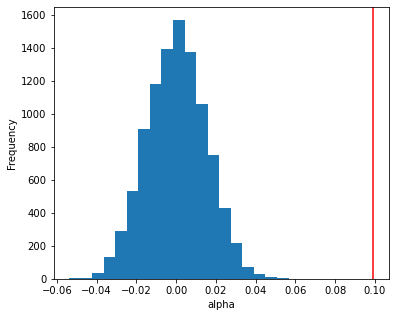

population median = 3e-05
population sd = 0.02591
sample median = 0.02118
boostrap p-value (greater than) = 0.0
boostrap p-value (less than) = 1.0



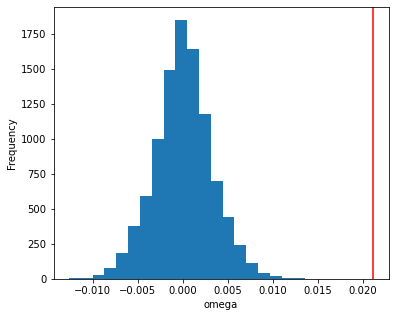

population median = 5e-05
population sd = 0.03939
sample median = -0.04953
boostrap p-value (greater than) = 1.0
boostrap p-value (less than) = 0.0



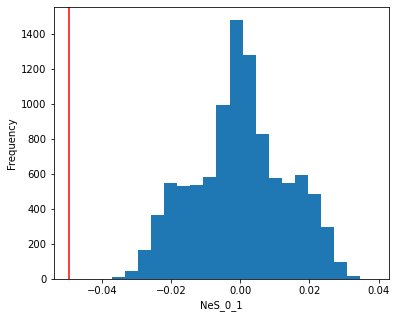

population median = 0.0
population sd = 0.0176
sample median = 0.00085
boostrap p-value (greater than) = 0.33133
boostrap p-value (less than) = 0.66867



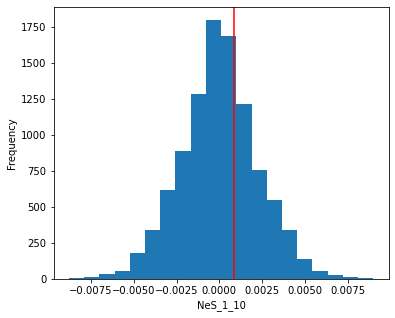

population median = 0.0
population sd = 0.02851
sample median = 0.00373
boostrap p-value (greater than) = 0.1445
boostrap p-value (less than) = 0.8555



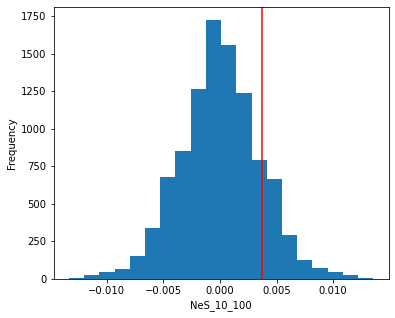

population median = -3e-05
population sd = 0.05338
sample median = 0.05088
boostrap p-value (greater than) = 0.0
boostrap p-value (less than) = 1.0



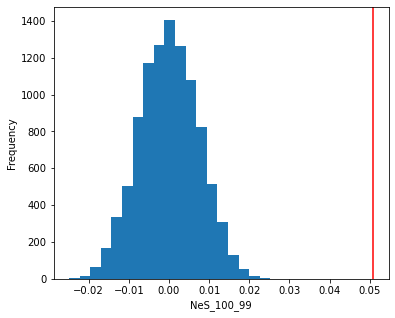

In [12]:

for col in sample_stats.columns:
    
    #annotation
    text_string = "population median = {}\n".format(round(population_summary.loc['median',col], 5))+ \
                    "population sd = {}\n".format(round(population_summary.loc['std',col], 5))+ \
                    "sample median = {}\n".format(round(df_summary.loc['median',col],5)) + \
                    'boostrap p-value (greater than) = {}\n'.format(round(sample_stats.loc['p_value_greater',col],5)) + \
                    'boostrap p-value (less than) = {}\n'.format(round(sample_stats.loc['p_value_less',col],5))
    print(text_string)
    
    #Figure
    plt.figure(figsize=(6, 5))
    population[population.index == 'median'][col].plot(kind = "hist", density = False, bins = 20)
    plt.xlabel(col)
    plt.axvline(x = df_summary.loc['median',col], color = 'red', \
                label='sample median\nx = {}'.format(df_summary.loc['median',col]))
    plt.show()